In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from shGLM_class import shGLM
from sklearn import metrics

# Hyperparams

In [2]:
train_T = 20000
test_T = 8000
syn_T = 351
C_den = torch.tensor([0,1,1,1,1])
sub_no = C_den.shape[0]

batch_size = 1250

syn_basis_no = 1
hist_basis_no = 3
spike_status = True
hist_T = 251


In [3]:
Ensyn = torch.tensor([0, 106, 213, 211, 99])
Insyn = torch.tensor([1, 22, 36, 42, 19])
N = torch.sum(Ensyn) + torch.sum(Insyn)
print(N)

C_syn = torch.zeros(sub_no, N)
count = 0
for m in range(sub_no):
    for e in range(Ensyn[m]):
        C_syn[m,count] = 1
        count += 1
        
for m in range(sub_no):
    for i in range(Insyn[m]):
        C_syn[m,count] = -1
        count += 1

tensor(749)


# Train ALL Params

In [4]:
fit_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
fit_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_nospike_s1_h3_shglm_i15500.pt"))


V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

train_V_ref = V_ref[:train_T]
test_V_ref = V_ref[train_T:train_T+test_T]

test_V_ref = torch.from_numpy(test_V_ref).cuda()
train_V_ref = torch.from_numpy(train_V_ref)

In [5]:
#adjust_K_hist = torch.ones(sub_no, hist_basis_tau.shape[0])*(-0.05)
#adjust_thresh = torch.ones(sub_no)*13
#adjust_spike_size = torch.ones(sub_no)*20
#adjust_thresh_scale = torch.ones(sub_no)*10
adjust_K_hist = torch.ones(sub_no, hist_basis_no)*(0.05)
adjust_thresh = torch.ones(sub_no)*7
adjust_spike_size = torch.ones(sub_no)*5
adjust_thresh_scale = torch.ones(sub_no)*5

with torch.no_grad():
    fit_shGLM.K_hist = nn.Parameter(adjust_K_hist.float(), requires_grad=True)
    fit_shGLM.thresh = nn.Parameter(adjust_thresh.float(), requires_grad=True)
    fit_shGLM.spike_size = nn.Parameter(adjust_spike_size, requires_grad=True)
    fit_shGLM.thresh_scale = nn.Parameter(adjust_thresh_scale, requires_grad=True)
    
fit_shGLM.cuda()

shGLM()

In [6]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

train_neural = np.hstack((E_neural, I_neural))[:train_T]
test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
train_neural = torch.from_numpy(train_neural)
test_neural = torch.from_numpy(test_neural).cuda()


In [7]:
repeat_no = 2
batch_no = (train_V_ref.shape[0] - batch_size) * repeat_no
train_idx = np.empty((repeat_no, train_V_ref.shape[0] - batch_size))
for i in range(repeat_no):
    part_idx = np.arange(train_V_ref.shape[0] - batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

print(batch_no)
print(train_idx.shape[0])

37500
37500


In [8]:
no_spike_bool = True
spike_bool = True

fit_shGLM.V_o.requires_grad = no_spike_bool
fit_shGLM.K_syn.requires_grad = no_spike_bool
fit_shGLM.Delta.requires_grad = no_spike_bool
fit_shGLM.C.requires_grad= no_spike_bool
fit_shGLM.Theta.requires_grad = no_spike_bool

fit_shGLM.thresh.requires_grad = spike_bool
fit_shGLM.spike_size.requires_grad = spike_bool
fit_shGLM.K_hist.requires_grad = spike_bool
fit_shGLM.thresh_scale.requires_grad = spike_bool


In [9]:
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.01)
optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.005)
#optimizer = optim.Adam(fit_shGLM.parameters(), lr=0.0005)

In [10]:
loss_array = np.empty((batch_no))

for i in tnrange(batch_no):
    fit_shGLM.train()
    optimizer.zero_grad()
    batch_idx = train_idx[i].long()
    batch_X = train_neural[batch_idx : batch_idx+batch_size].float().cuda()
    batch_pred = fit_shGLM(batch_X)
    batch_ref = train_V_ref[batch_idx:batch_idx+batch_size].cuda()
    
    #loss = criterion(batch_ref, batch_pred)
    
    diff = (batch_ref - batch_pred) ** 1
    loss = torch.var(diff)
    loss_array[i] = loss.item()
    
    #print(i, train_score)
    
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if i%100 == 0:
        fit_shGLM.eval()
        test_pred = fit_shGLM(test_neural.float())
        #test_loss = criterion(test_V_ref, test_pred)
        test_diff = (test_V_ref - test_pred) ** 1
        test_loss = torch.var(test_diff)
        test_score = metrics.explained_variance_score(y_true=test_V_ref.cpu().detach().numpy(),
                                                      y_pred=test_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        train_score = metrics.explained_variance_score(y_true=batch_ref.cpu().detach().numpy(),
                                                      y_pred=batch_pred.cpu().detach().numpy(),
                                                      multioutput='uniform_average')
        print("TEST", i, test_loss.item(), test_score, train_score)
        if i%100 == 0:
            torch.save(fit_shGLM.state_dict(), "/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s1_h3_shglm_i"+str(i)+".pt")
    


<ipython-input-10-41dd44a638bb>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(batch_no):


TEST 0 2.996709650881756 0.7830249630071332 -0.10278866842143652
TEST 100 2.2501012572187564 0.8370827137827745 0.3616011558007213
TEST 200 2.3279995413319154 0.8314425333538612 0.6985038499220136
TEST 300 2.50400898924561 0.8186986707573184 0.7921547702983653
TEST 400 2.1141796342177908 0.8469240407667956 0.6896651748610725
TEST 500 3.127213056456705 0.7735759391275686 0.6177724216121767
TEST 600 2.203904517923978 0.8404275622380128 0.693824854381612
TEST 700 1.8812965571137334 0.8637858058368544 0.7192155359709673
TEST 800 1.8430425179805108 0.8665555675788991 0.7257415300007889
TEST 900 1.8174269273188617 0.8684102496906927 0.8285964674331773
TEST 1000 1.820367791237936 0.8681973181338114 0.8510046133506934
TEST 1100 1.7546443943290437 0.8729559827781109 0.518057452900756
TEST 1200 1.7706725488392567 0.8717954735690467 0.7573696698584345
TEST 1300 1.7599160794577062 0.8725742894878018 0.7499916251917215
TEST 1400 2.2453286397372523 0.8374282723682036 0.6225929620523758
TEST 1500 1.8

KeyboardInterrupt: 

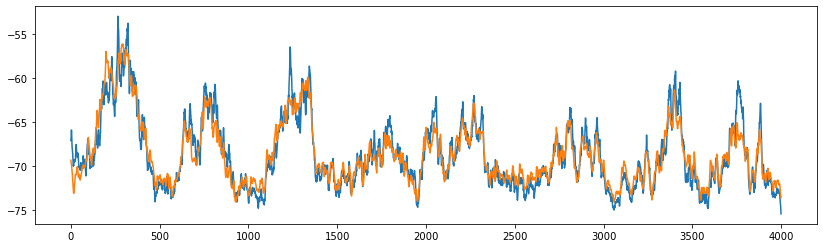

In [14]:
plt.figure(figsize=(14,4))
plt.plot(test_V_ref.cpu().detach().numpy()[:4000])
plt.plot(test_pred.cpu().detach().numpy()[:4000]+1.5)

In [15]:
for name, param in fit_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-78.8566], device='cuda:0')
K_syn tensor([[[ 0.0151, -0.0462]],

        [[ 0.1800, -0.1464]],

        [[ 0.1850, -0.0974]],

        [[ 0.1022, -0.0743]],

        [[ 0.2293, -0.2179]]], device='cuda:0')
syn_basis_tau tensor([1.4305], device='cuda:0')
Delta tensor([5.0720], device='cuda:0')
C tensor([ 2.7409,  0.1597,  0.1368,  0.7546, -0.0225], device='cuda:0')
Theta tensor([2.2604, 0.5598, 0.9563, 0.1371, 0.6975], device='cuda:0')
thresh tensor([7.0770, 6.9897, 6.8382, 6.9573, 6.7568], device='cuda:0')
thresh_scale tensor([5.0852, 5.2587, 4.9905, 4.9395, 4.9926], device='cuda:0')
spike_size tensor([4.9720, 3.4160, 4.3898, 4.4649, 3.2384], device='cuda:0')
hist_basis_tau tensor([1.3424, 2.1111, 2.0997], device='cuda:0')
K_hist tensor([[-0.2261,  0.4619,  0.7078],
        [ 0.5336,  1.0939,  1.0247],
        [ 0.4394,  0.9157,  1.1597],
        [ 0.4589,  0.9683,  0.9499],
        [ 0.4558,  1.0368,  0.9231]], device='cuda:0')


# Test Params

In [4]:
final_shGLM = shGLM(C_den, C_syn, syn_T, Ensyn,
                 syn_basis_no, hist_basis_no,
                 spike_status, hist_T)
final_shGLM.load_state_dict(torch.load("/media/hdd01/sklee/shglm/biophysical/final_fit/final5_spike5_s1_h3_shglm_i5700.pt"))

final_shGLM.eval().cuda()

V_ref = np.fromfile("/media/hdd01/sklee/hglm/biophysical/inputs/vdata_NMDA_ApN0.5_13_Adend_r0_o2_i2_g_b0.bin")
V_ref = V_ref[1:-2]

test_V_ref = V_ref[train_T:train_T+test_T]


In [5]:
E_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Espikes_d48000_r1_rep1_Ne629_e5_E20_neural.npy")
I_neural = np.load("/media/hdd01/sklee/shglm/biophysical/inputs/Ispikes_d48000_r1_rep1_Ni120_i20_I30_neural.npy")

test_neural = np.hstack((E_neural, I_neural))[train_T:train_T + test_T]
test_neural = torch.from_numpy(test_neural).float().cuda()

test_V_final = final_shGLM(test_neural).cpu().detach().numpy()

test_V_final = test_V_final
test_V_ref = test_V_ref

0.9487722044526897


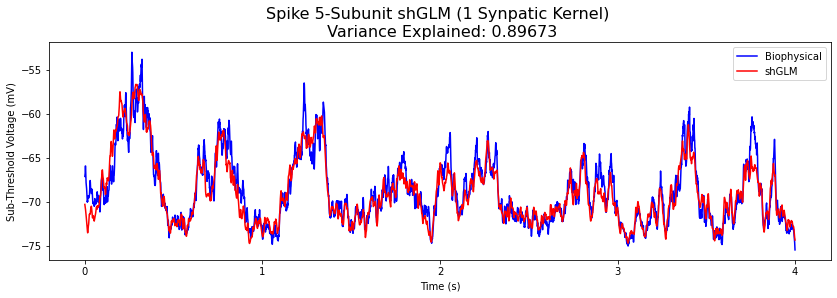

In [11]:
plt.figure(figsize = (14,4))
plt.plot(test_V_ref[:4000], label="Biophysical", c="blue")
plt.plot(test_V_final[:4000]+0.7, label="shGLM", c="red")
print(np.corrcoef(test_V_ref, test_V_final)[0][1])


test_score = metrics.explained_variance_score(y_true=test_V_ref,
                                                      y_pred=test_V_final,
                                                      multioutput='uniform_average')

plt.title("Spike 5-Subunit shGLM (1 Synpatic Kernel) \n Variance Explained: " + str(round(test_score, 5)), fontsize = 16)
#plt.xticks(np.arange(0,8001,1000),[0,1,2,3,4,5,6,7,8])
plt.xticks(np.arange(0,4001,1000),[0,1,2,3,4])
plt.xlabel("Time (s)")
plt.ylabel("Sub-Threshold Voltage (mV)")
plt.legend()
#plt.show()


plt.savefig("/media/hdd01/sklee/shglm/biophysical/final5_spike5_s1_h3_shGLM.png", dpi=150, bbox_inches='tight')#

In [8]:
for name, param in final_shGLM.named_parameters():
    print(name, param.data)

V_o tensor([-79.4190], device='cuda:0')
K_syn tensor([[[ 0.0186, -0.0367]],

        [[ 0.0862, -0.0449]],

        [[ 0.1708, -0.0800]],

        [[ 0.0897, -0.0703]],

        [[ 0.1138, -0.0868]]], device='cuda:0')
Delta tensor([4.6886], device='cuda:0')
C tensor([2.6362, 0.7447, 0.2647, 0.9421, 0.7483], device='cuda:0')
Theta tensor([2.6014, 0.3229, 0.9865, 0.4672, 0.9608], device='cuda:0')
thresh tensor([7.3735, 7.4527, 7.4143, 7.5145, 7.2735], device='cuda:0')
thresh_scale tensor([5.1589, 5.3248, 5.0371, 4.7914, 5.6756], device='cuda:0')
spike_size tensor([6.3295, 4.7767, 5.2421, 4.3874, 5.5679], device='cuda:0')
K_hist tensor([[-0.4870,  0.6500,  1.3475],
        [ 0.6974,  1.2893,  1.7567],
        [ 0.6221,  1.3967,  1.9258],
        [ 0.5438,  1.4835,  2.1612],
        [ 0.8520,  1.2770,  1.4451]], device='cuda:0')
